# Assignment 2 - Sentiment and NER 
For this assignment, I'll write a small Python program to perform NER and sentiment analysis.  
I have chosen task 2. 

**Description:**  
Using the corpus of Fake vs Real news, write some code which does the following

 1. Split the data into two datasets - one of Fake news and one of Real news
 2. For every headline 
     * Get the sentiment scores
     * Find all mentions of geopolitical entites
     * Save a CSV which shows the text ID, the sentiment scores, and column showing all GPEs in that text
 3. Find the 20 most common geopolitical entities mentioned across each dataset - plot the results as a bar charts

## Preperation: Loading packages and data

In [84]:
# Packages for data analysis
import os
import pandas as pd
from collections import Counter
from tqdm import tqdm

# Package for NLP
import spacy
nlp = spacy.load("en_core_web_sm")

# Packages for sentiment analysis VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Package for visualisations
import matplotlib.pyplot as plt

In [85]:
# get the filepath 
filename = os.path.join("..", "..", "..", "CDS-LANG", "tabular_examples", "fake_or_real_news.csv")

In [86]:
# load the data
data = pd.read_csv(filename)

In [87]:
data

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


## Task 1: Split the data into two datasets - one of Fake news and one of Real news

To filter on columns, I define a condition on which I want to filter and use that to filer my new DataFrame. In this case I want to use the column named ```label``` and then select either ```FAKE``` or ```REAL```.  
I use the square-bracket syntax, just as if I were slicing a list or string.

### Fake news

In [88]:
# create dataframe with Fake news
fake_news_df = data[data["label"]=="FAKE"]

# let's have a look at our new pretty dataframe with all the fake news
fake_news_df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
...,...,...,...,...
6326,6143,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,FAKE
6328,9337,Radio Derb Is On The Air–Leonardo And Brazil’s...,,FAKE
6329,8737,Assange claims ‘crazed’ Clinton campaign tried...,Julian Assange has claimed the Hillary Clinton...,FAKE
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE


### Real news

In [89]:
# create dataset with Real news
real_news_df = data[data["label"]=="REAL"]

# let's have a look at our real news!
real_news_df

,Unnamed: 0,title,text,label
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL
...,...,...,...,...
6324,2316,Alabama Lawmaker: Same-Sex Couples Don’t Deser...,Most conservatives who oppose marriage equalit...,REAL
6327,3262,GOP Senator David Perdue Jokes About Praying f...,The freshman senator from Georgia quoted scrip...,REAL
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


## Task 2.1.: For every headline... get the sentiment scores 
I have chosen to use VADER for my sentiment analysis.

### Fake news

Step 1: Get polarity score for all headlines in the fake news dataframe

In [90]:
# create empty list
vader_scores_fake = [] 

# for every headline in the fake news df using the column named "title"
for headline in fake_news_df["title"]: 
    # get the polarity score of the headline
    score = analyzer.polarity_scores(headline) 
    # append score to empty list
    vader_scores_fake.append(score) 

Step 2: Convert list to dataframe and display it. 

In [91]:
# convert to dataframe
vader_df_fake = pd.DataFrame(vader_scores_fake)

In [92]:
# display
vader_df_fake

,neg,neu,pos,compound
0,0.444,0.556,0.000,-0.4939
1,0.242,0.645,0.113,-0.5267
2,0.266,0.591,0.143,-0.3595
3,0.000,1.000,0.000,0.0000
4,0.226,0.774,0.000,-0.5423
...,...,...,...,...
3159,0.465,0.535,0.000,-0.7804
3160,0.118,0.882,0.000,-0.1531
3161,0.000,1.000,0.000,0.0000
3162,0.000,1.000,0.000,0.0000


### Real news

Step 1: Get polarity score for all headlines in the real news dataframe

In [93]:
# create empty list
vader_scores_real = []

# for every headline in the real news df using the column "title"
for headline in real_news_df["title"]:
    # get the polarity score of the headline
    score = analyzer.polarity_scores(headline)
    # append score to empty list
    vader_scores_real.append(score)

Step 2: Convert list to dataframe and display it. 

In [94]:
# convert to dataframe
vader_df_real = pd.DataFrame(vader_scores_real)

In [95]:
# display
vader_df_real

,neg,neu,pos,compound
0,0.000,0.762,0.238,0.3612
1,0.243,0.654,0.103,-0.3612
2,0.000,1.000,0.000,0.0000
3,0.000,1.000,0.000,0.0000
4,0.000,1.000,0.000,0.0000
...,...,...,...,...
3166,0.000,0.809,0.191,0.3818
3167,0.253,0.455,0.292,-0.1027
3168,0.000,1.000,0.000,0.0000
3169,0.000,0.479,0.521,0.8271


## Task 2.2.: For every headline... find all mentions of geopolitical entites  
I'll be doing a NER using ```spaCy``` in order to find every individual occurrence of some kind of named entity, in this case the mentions of all geopolitical entities (shortened to GPE). 

In [96]:
# But what does GPE cover? Let's have a look
spacy.explain("GPE")

'Countries, cities, states'

### Fake News

Step 1: Find batch size for dataset.

In [97]:
# find batch size for fake news
fake_news_df["label"].value_counts()

FAKE    3164
Name: label, dtype: int64

Step 2: Find GPE in headlines in the fake news dataframe

In [100]:
# create empty list
fake_gpe = []

# for every headline in tqdm (I'm not quite sure what tqdm stands for...), pipe through fake news df using the column "title" and go through 3164 of them
for headline in tqdm(nlp.pipe(fake_news_df["title"], batch_size=3164)):
    # and for every entity in these headlines
    for entity in headline.ents:
        # if that entity is labeled "GPE"
        if entity.label_ == "GPE":
            fake_gpe.append(entity.text)

3164it [00:03, 996.38it/s]


### Real news

Step 1: Find batch size for dataset.

In [101]:
# find batch size for real news
real_news_df["label"].value_counts()

REAL    3171
Name: label, dtype: int64

Step 2: Find GPE in headlines in the fake news dataframe

In [102]:
# Create empty list
real_gpe = []

# for every headline in tqdm (I'm not quite sure what tqdm stands for...), pipe through real news df using the column "title" and go through 3171 of them
for headline in tqdm(nlp.pipe(real_news_df["title"], batch_size=3171)):
    # and for every entity in these headlines
    for entity in headline.ents:
        # if that entity is labeled "GPE"
        if entity.label_ == "GPE":
            # append to real_gpe
            real_gpe.append(entity.text)

3171it [00:03, 912.06it/s]


## Task 2.3.: Save a CSV which shows the text ID, the sentiment scores, and column showing all GPEs in that text

### Fake news

In [103]:
# Make list with text ID, sentiment score and GPE
list_fake = list(zip(fake_news_df["Unnamed: 0"], vader_df_fake["neg"], vader_df_fake["neu"], vader_df_fake["pos"], fake_gpe))

# Convert to dataframe
data_fake = pd.DataFrame(list_fake, columns = ["Text ID", "Negative", "Neutral", "Positive", "GPE"]) 

# display new dataframe with fake news
data_fake

,Text ID,Negative,Neutral,Positive,GPE
0,8476,0.444,0.556,0.000,Tehran
1,10294,0.242,0.645,0.113,USA
2,10142,0.266,0.591,0.143,UK
3,6903,0.000,1.000,0.000,Russia
4,7341,0.226,0.774,0.000,Empire
...,...,...,...,...,...
805,9724,0.000,1.000,0.000,Turkey
806,6674,0.000,0.476,0.524,Oakland
807,10284,0.464,0.536,0.000,Vatican
808,5383,0.000,1.000,0.000,US


In [104]:
# Convert to csv
data_fake.to_csv("output_fake.csv", encoding = "utf-8")

### Real news

In [105]:
# Make a list with text ID, sentiment score and GPE
list_real = list(zip(real_news_df["Unnamed: 0"], vader_df_real["neg"], vader_df_real["neu"], vader_df_real["pos"], real_gpe))

# Convert to dataframe
data_real = pd.DataFrame(list_real, columns = ["Text ID", "Negative", "Neutral", "Positive", "GPE"]) 

# display new dataframe with real news
data_real

,Text ID,Negative,Neutral,Positive,GPE
0,3608,0.000,0.762,0.238,Paris
1,875,0.243,0.654,0.103,New York
2,95,0.000,1.000,0.000,Iran
3,4869,0.000,1.000,0.000,Iowa
4,2909,0.000,1.000,0.000,Iran
...,...,...,...,...,...
1025,3440,0.234,0.541,0.225,Texas
1026,947,0.204,0.796,0.000,New Hampshire
1027,734,0.000,0.800,0.200,Ethiopia
1028,2514,0.211,0.789,0.000,Obama


In [106]:
# convert to csv
data_real.to_csv("output_real.csv", encoding = "utf-8")

## Task 3: Find the 20 most common geopolitical entities mentioned across each dataset and plot the results as a bar charts

### Fake news

In [107]:
# count the frequency of each GPE in fake news
fake_gpe_count = data_fake.value_counts('GPE')

# take the 20 most common GPE
fake_gpe_top20 = fake_gpe_count.nlargest(20)

# display
fake_gpe_top20

GPE
US              104
Russia           93
U.S.             39
Syria            38
America          36
Israel           19
Mosul            18
China            15
UK               12
Obama            12
Yemen            11
Iran             10
India            10
Saudi Arabia     10
Florida          10
France            9
Turkey            8
Washington        8
Iraq              8
Italy             7
dtype: int64

As we can see it is a problem that there is both US and U.S. since they refere to the same country (United States). But since I'm short on time, I won't do anything further about it. 

In [108]:
# convert to list
fake_top20 = fake_gpe_top20.tolist()

#zip value and key
fake_top20 = list(zip(fake_gpe_top20.index, fake_top20))

# display
fake_top20

[('US', 104),
 ('Russia', 93),
 ('U.S.', 39),
 ('Syria', 38),
 ('America', 36),
 ('Israel', 19),
 ('Mosul', 18),
 ('China', 15),
 ('UK', 12),
 ('Obama', 12),
 ('Yemen', 11),
 ('Iran', 10),
 ('India', 10),
 ('Saudi Arabia', 10),
 ('Florida', 10),
 ('France', 9),
 ('Turkey', 8),
 ('Washington', 8),
 ('Iraq', 8),
 ('Italy', 7)]

Apparently Jupyter is forgetful and I have to load ```numpy``` and ```matplotlib``` again. 

In [109]:
import numpy as np
import matplotlib.pyplot as plt

Now I can move on and visualize the 20 most common GPE in a bar chart

<BarContainer object of 20 artists>

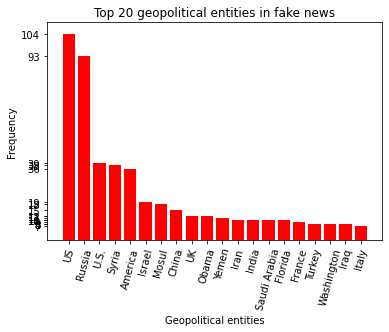

In [110]:
# define pairs of x and y
labels, y = zip(*fake_top20)
x = np.arange(len(labels))

# plot into bar chart
plt.xticks(x, labels, rotation=75)
plt.yticks(y)

# add axes labels
plt.xlabel("Geopolitical entities")
plt.ylabel("Frequency")

# add title
plt.title("Top 20 geopolitical entities in fake news")

# I would like to change the y axis using the following code, but I can't get it to work
plt.ylim(0,110)

# plot as bar chart
plt.bar(x, y, color = "red", width = 0.8)

### Real news

In [111]:
# count the frequency of each GPE in real news
real_gpe_count = data_real.value_counts('GPE')

# take the 20 most common GPE
real_gpe_top20 = real_gpe_count.nlargest(20)

# display
real_gpe_top20

GPE
Obama            129
Iran              94
US                60
America           49
U.S.              42
Iowa              42
Syria             29
Russia            23
Paris             22
New Hampshire     20
Iraq              18
California        14
Washington        13
New York          13
Nevada            13
Israel            13
Kasich            13
Baltimore         12
Cuba              12
Charleston        11
dtype: int64

As we can see it is a problem that there is both US and U.S. since they refere to the same country (United States). But since I'm short on time, I won't do anything further about it. 

In [112]:
# convert to list
real_top20 = real_gpe_top20.tolist()

# zip value and key
real_top20 = list(zip(real_gpe_top20.index, real_top20))

# display
real_top20

[('Obama', 129),
 ('Iran', 94),
 ('US', 60),
 ('America', 49),
 ('U.S.', 42),
 ('Iowa', 42),
 ('Syria', 29),
 ('Russia', 23),
 ('Paris', 22),
 ('New Hampshire', 20),
 ('Iraq', 18),
 ('California', 14),
 ('Washington', 13),
 ('New York', 13),
 ('Nevada', 13),
 ('Israel', 13),
 ('Kasich', 13),
 ('Baltimore', 12),
 ('Cuba', 12),
 ('Charleston', 11)]

<BarContainer object of 20 artists>

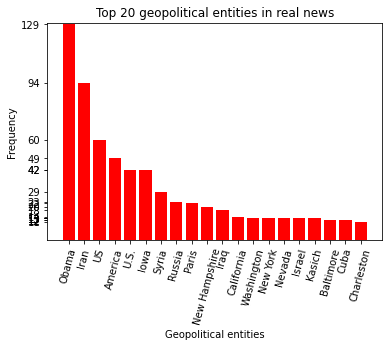

In [113]:
# Define pairs of x and y
labels, y = zip(*real_top20)
x = np.arange(len(labels))

# Plot into bar chart
plt.xticks(x, labels, rotation=75)
plt.yticks(y)

# add axes labels
plt.xlabel("Geopolitical entities")
plt.ylabel("Frequency")

# add title
plt.title("Top 20 geopolitical entities in real news")

# I would like to change the y axis using the following code, but I can't get it to work
plt.ylim(0,130)

# plot as bar chart
plt.bar(x, y, color = "red", width = 0.8)